In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k, model_metrics
from src.utils import prefilter_items, get_candidates, get_base_dataset, add_features, get_model_recs
from src.recommenders import MainRecommender

from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer

In [2]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

In [3]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# max 95
# -- train, < 86 -- / -- val1, 86..92 -- / -- val2, 92+ --
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
val1_users = len(set(data_val_lvl_1['user_id']))
new_val1_users = len(set(data_val_lvl_1['user_id']) - set(data_train_lvl_1['user_id']))

val2_users = len(set(data_val_lvl_2['user_id']))
new_val2_users = len(set(data_val_lvl_2['user_id']) - set(data_train_lvl_1['user_id']))

print('В val1 дата сете {} юзеров'.format(val1_users))
print('В val1 дата сете {} новых юзеров'.format(new_val1_users))

print('В val2 дата сете {} юзеров'.format(val2_users))
print('В val2 дата сете {} новых юзеров'.format(new_val2_users))

В val1 дата сете 2154 юзеров
В val1 дата сете 1 новых юзеров
В val2 дата сете 2042 юзеров
В val2 дата сете 1 новых юзеров


In [5]:
train_users = set(data_train_lvl_1['user_id'])
data_val_lvl_1 = data_val_lvl_1[data_val_lvl_1['user_id'].isin(data_train_lvl_1['user_id'])]
data_val_lvl_2 = data_val_lvl_2[data_val_lvl_2['user_id'].isin(data_train_lvl_1['user_id'])]

### level 1

In [6]:
n_items_before = data_train_lvl_1['item_id'].nunique() # куплены 9 недель назад и ранее до фильтрации

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features)

n_items_after = data_train_lvl_1['item_id'].nunique() # куплены 9 недель назад и ранее после фильтрации
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

C:\Users\snetkova\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\snetkova\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\snetkova\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

Decreased # items from 83685 to 25072


In [7]:
recommender = MainRecommender(data_train_lvl_1)

#### methods compare

In [8]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [9]:
%%time
result_lvl_1['als_recommendation'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))
result_lvl_1.head(2)

Wall time: 1min 42s


,user_id,actual,als_recommendation
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1075074, 1006546, 1087232, 819518, 958046, 98..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[903674, 1119879, 971504, 1068719, 866950, 100..."


In [10]:
%%time
result_lvl_1['own_recommendation'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
result_lvl_1.head(2)

Wall time: 28 s


,user_id,actual,als_recommendation,own_recommendation
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1075074, 1006546, 1087232, 819518, 958046, 98...","[1049998, 1006546, 931136, 1055201, 1035805, 9..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[903674, 1119879, 971504, 1068719, 866950, 100...","[826784, 831125, 9365871, 1069575, 889511, 926..."


In [11]:
# %%time
# result_lvl_1['similar_items_recommendation'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))
# result_lvl_1.head(2)

In [12]:
# %%time
# result_lvl_1['similar_users_recommendation'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))
# result_lvl_1.head(2)

In [13]:
result_lvl_1.apply(lambda row: precision_at_k(row['als_recommendation'], row['actual']), axis=1).mean()

0.15401764979098764

In [14]:
result_lvl_1.apply(lambda row: precision_at_k(row['own_recommendation'], row['actual']), axis=1).mean()

0.20260102183000278

In [15]:
# result_lvl_1.apply(lambda row: precision_at_k(row['similar_items_recommendation'], row['actual']), axis=1).mean()

In [16]:
# result_lvl_1.apply(lambda row: precision_at_k(row['similar_users_recommendation'], row['actual']), axis=1).mean()

In [17]:
result_lvl_1.apply(lambda row: recall_at_k(row['als_recommendation'], row['actual']), axis=1).mean()

0.014482696873896153

In [18]:
result_lvl_1.apply(lambda row: recall_at_k(row['own_recommendation'], row['actual']), axis=1).mean()

0.019474300076327354

In [19]:
# result_lvl_1.apply(lambda row: recall_at_k(row['similar_items_recommendation'], row['actual']), axis=1).mean()

In [20]:
# result_lvl_1.apply(lambda row: recall_at_k(row['similar_users_recommendation'], row['actual']), axis=1).mean()

own recommendations + top-popular дали метрики выше

#### best k search

In [21]:
# res = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
# res.columns=['user_id', 'actual']
# res.head(2)

In [22]:
# metrics = {}
# for k in [50, 100, 200]:
#     res['own' + str(k)] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=k))
#     metrics['own' + str(k)] = res.apply(lambda row: recall_at_k(row['own' + str(k)], row['actual'], k), axis=1).mean()
# res.head()
# metrics

С увеличением количества рекомендуемых товаров метрика recall@k растет. Остановимся на 100

### level 2

#### datasets

In [23]:
rec_func = recommender.get_own_recommendations
score_func = recommender.get_own_scores

In [24]:
# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique() # data_train_lvl_1!!!

In [25]:
%%time
users_lvl_2 = get_candidates(data_train_lvl_2, rec_func, score_func, train_users, 100)
users_lvl_2.head(2)

Wall time: 56.9 s


,user_id,item_id,item_score,flag
0,2070,834103,14437.832795,1
1,2070,878302,14341.921843,1


In [26]:
%%time
users_lvl_2_val = get_candidates(data_val_lvl_2, rec_func, score_func, train_users, 100)
users_lvl_2_val.head(2)

Wall time: 52.6 s


,user_id,item_id,item_score,flag
0,338,906839,15310.451793,1
1,338,924760,15096.454315,1


In [27]:
users_lvl_2.shape[0], users_lvl_2['user_id'].nunique()

(215300, 2153)

In [28]:
users_lvl_2_val.shape[0], users_lvl_2_val['user_id'].nunique()

(204100, 2041)

In [29]:
targets_lvl_2 = get_base_dataset(data_train_lvl_2, users_lvl_2)
targets_lvl_2.head(2)

,user_id,item_id,item_score,target
0,2070,834103,14437.832795,1.0
1,2070,878302,14341.921843,1.0


In [30]:
targets_lvl_2_val = get_base_dataset(data_val_lvl_2, users_lvl_2_val)
targets_lvl_2_val.head(2)

,user_id,item_id,item_score,target
0,338,906839,15310.451793,0.0
1,338,924760,15096.454315,0.0


In [31]:
targets_lvl_2['target'].mean(), targets_lvl_2_val['target'].mean()

(0.06601021830004644, 0.04979421852033317)

#### features

In [32]:
targets_lvl_2 = add_features(targets_lvl_2, data, item_features, user_features)
targets_lvl_2.head(2)

C:\Users\snetkova\AI_rec_sys\src\utils.py:96: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  user_stats = stats.groupby('user_id')['quantity', 'sales_value', 'week_no', 'basket_id'].agg(money = ('sales_value', 'sum'), qty = ('quantity', 'sum'),  bask = ('basket_id', 'nunique'), wk = ('week_no', 'nunique')).reset_index()
C:\Users\snetkova\AI_rec_sys\src\utils.py:102: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  item_stats = stats.groupby('item_id')['quantity', 'sales_value', 'week_no'].agg(money = ('sales_value', 'sum'), qty = ('quantity', 'sum'), wk = ('week_no', 'nunique')).reset_index()


,user_id,item_id,item_score,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,...,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,avg_bill,weekly_purch,d_qty,m_qty
0,2070,834103,14437.832795,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,...,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,6.585366,1553.0,95.0
1,2070,878302,14341.921843,1.0,544,GROCERY,National,BAG SNACKS,SGL SV/VEND MACH SNACKS CHIP/P,1 OZ,...,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,6.585366,1553.0,81.0


In [33]:
targets_lvl_2_val = add_features(targets_lvl_2_val, data, item_features, user_features)
targets_lvl_2_val.head(2)

C:\Users\snetkova\AI_rec_sys\src\utils.py:96: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  user_stats = stats.groupby('user_id')['quantity', 'sales_value', 'week_no', 'basket_id'].agg(money = ('sales_value', 'sum'), qty = ('quantity', 'sum'),  bask = ('basket_id', 'nunique'), wk = ('week_no', 'nunique')).reset_index()
C:\Users\snetkova\AI_rec_sys\src\utils.py:102: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  item_stats = stats.groupby('item_id')['quantity', 'sales_value', 'week_no'].agg(money = ('sales_value', 'sum'), qty = ('quantity', 'sum'), wk = ('week_no', 'nunique')).reset_index()


,user_id,item_id,item_score,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,...,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,avg_bill,weekly_purch,d_qty,m_qty
0,338,906839,15310.451793,0.0,916,GROCERY,National,HISPANIC,CENTRAL AMERICAN FOODS,1.41 OZ,...,NaN,NaN,NaN,NaN,NaN,NaN,17.597969,2.245614,396.0,8.0
1,338,924760,15096.454315,0.0,69,GROCERY,Private,DRY NOODLES/PASTA,SPAGHETTI DRY,16OZ,...,NaN,NaN,NaN,NaN,NaN,NaN,17.597969,2.245614,396.0,273.0


In [34]:
# производитель, user_id, item_id - категориальные фичи
targets_lvl_2[['user_id', 'item_id', 'manufacturer']] = targets_lvl_2[['user_id', 'item_id', 'manufacturer']].astype('category')
targets_lvl_2_val[['user_id', 'item_id', 'manufacturer']] = targets_lvl_2_val[['user_id', 'item_id', 'manufacturer']].astype('category')

In [35]:
targets_lvl_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215300 entries, 0 to 215299
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   user_id               215300 non-null  category
 1   item_id               215300 non-null  category
 2   item_score            215300 non-null  float64 
 3   target                215300 non-null  float64 
 4   manufacturer          215300 non-null  category
 5   department            215300 non-null  object  
 6   brand                 215300 non-null  object  
 7   commodity_desc        215300 non-null  object  
 8   sub_commodity_desc    215300 non-null  object  
 9   curr_size_of_product  215300 non-null  object  
 10  price                 215300 non-null  float64 
 11  weekly                215300 non-null  float64 
 12  age_desc              79100 non-null   object  
 13  marital_status_code   79100 non-null   object  
 14  income_desc           79100 non-null

In [36]:
targets_lvl_2_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204100 entries, 0 to 204099
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   user_id               204100 non-null  category
 1   item_id               204100 non-null  category
 2   item_score            204100 non-null  float64 
 3   target                204100 non-null  float64 
 4   manufacturer          204100 non-null  category
 5   department            204100 non-null  object  
 6   brand                 204100 non-null  object  
 7   commodity_desc        204100 non-null  object  
 8   sub_commodity_desc    204100 non-null  object  
 9   curr_size_of_product  204100 non-null  object  
 10  price                 204100 non-null  float64 
 11  weekly                204100 non-null  float64 
 12  age_desc              76400 non-null   object  
 13  marital_status_code   76400 non-null   object  
 14  income_desc           76400 non-null

In [37]:
# появились пропуски в d_qty, m_qty - юзеры такого раньше не покупали

#### train/test preparation

In [38]:
data_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

data_val = targets_lvl_2_val.drop('target', axis=1)
y_val = targets_lvl_2_val[['target']]

In [39]:
num_feats = data_train.select_dtypes(include = ['float64', 'int64']).columns.tolist()
cat_feats = data_train.select_dtypes(include = ['object', 'category']).columns.tolist()
num_feats, cat_feats

(['item_score',
  'price',
  'weekly',
  'avg_bill',
  'weekly_purch',
  'd_qty',
  'm_qty'],
 ['user_id',
  'item_id',
  'manufacturer',
  'department',
  'brand',
  'commodity_desc',
  'sub_commodity_desc',
  'curr_size_of_product',
  'age_desc',
  'marital_status_code',
  'income_desc',
  'homeowner_desc',
  'hh_comp_desc',
  'household_size_desc',
  'kid_category_desc'])

In [40]:
%%time
# будет долго, ~5 мин
imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent", verbose = 2)
imp_train = pd.DataFrame(imp.fit_transform(data_train))
imp_val = pd.DataFrame(imp.transform(data_val))

Wall time: 4min 22s


In [41]:
imp_train.columns = data_train.columns
imp_val.columns = data_val.columns
imp_train.head()

,user_id,item_id,item_score,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,price,...,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,avg_bill,weekly_purch,d_qty,m_qty
0,2070,834103,14437.8,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,0.00658881,...,U,50-74K,Unknown,Unknown,1,None/Unknown,12.9294,6.58537,1553,95
1,2070,878302,14341.9,544,GROCERY,National,BAG SNACKS,SGL SV/VEND MACH SNACKS CHIP/P,1 OZ,0.00239048,...,U,50-74K,Unknown,Unknown,1,None/Unknown,12.9294,6.58537,1553,81
2,2070,1119399,14171.8,69,GROCERY,Private,FLUID MILK PRODUCTS,CHOCOLATE MILK,1 QT,0.00222568,...,U,50-74K,Unknown,Unknown,1,None/Unknown,12.9294,6.58537,1553,623
3,2070,936508,13728.7,531,GROCERY,National,FLUID MILK PRODUCTS,CHOCOLATE MILK,PT,0.00415287,...,U,50-74K,Unknown,Unknown,1,None/Unknown,12.9294,6.58537,1553,16
4,2070,1107824,13156.1,544,GROCERY,National,WAREHOUSE SNACKS,SNACK MIX,7.75 OZ,0.00258304,...,U,50-74K,Unknown,Unknown,1,None/Unknown,12.9294,6.58537,1553,81


In [42]:
imp_train[num_feats] = imp_train[num_feats].astype('float64')
imp_val[num_feats] = imp_val[num_feats].astype('float64')

imp_train[cat_feats] = imp_train[cat_feats].astype('category')
imp_val[cat_feats] = imp_val[cat_feats].astype('category')

imp_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215300 entries, 0 to 215299
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   user_id               215300 non-null  category
 1   item_id               215300 non-null  category
 2   item_score            215300 non-null  float64 
 3   manufacturer          215300 non-null  category
 4   department            215300 non-null  category
 5   brand                 215300 non-null  category
 6   commodity_desc        215300 non-null  category
 7   sub_commodity_desc    215300 non-null  category
 8   curr_size_of_product  215300 non-null  category
 9   price                 215300 non-null  float64 
 10  weekly                215300 non-null  float64 
 11  age_desc              215300 non-null  category
 12  marital_status_code   215300 non-null  category
 13  income_desc           215300 non-null  category
 14  homeowner_desc        215300 non-nul

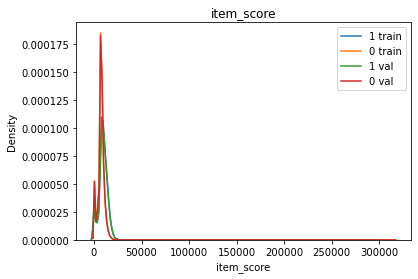

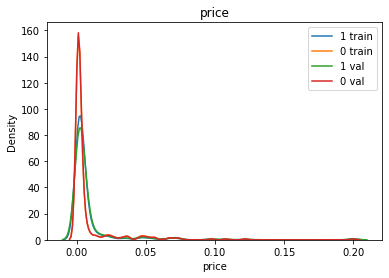

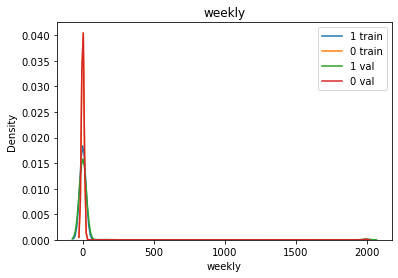

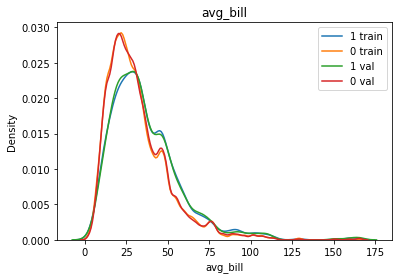

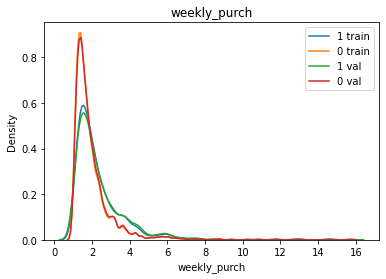

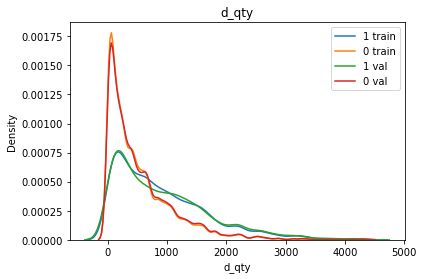

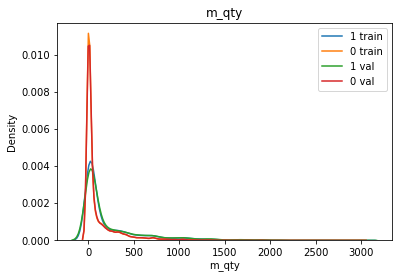

In [43]:
for i in data_train[num_feats]:
        sns.kdeplot(data_train.loc[y_train.values == 1,i], label = '1 train')
        sns.kdeplot(data_train.loc[y_train.values == 0,i], label ='0 train')
        
        sns.kdeplot(data_val.loc[y_val.values == 1,i], label = '1 val')
        sns.kdeplot(data_val.loc[y_val.values == 0,i], label =  '0 val')
        
        plt.title(i)
        plt.legend()
        plt.show()

#### model train

In [44]:
X_train = imp_train.copy()
X_val = imp_val.copy()

In [45]:
# model_catb = CatBoostClassifier(silent = True, random_state = 42)

In [46]:
# params_catb = {
#         'max_depth': [5, 7, 10],
#         'min_data_in_leaf': [100, 500, 1000],
#         'n_estimators': [100, 500, 1000],
#         'learning_rate': list(np.linspace(0.01, 0.20, 6)), #eta
#         'reg_lambda': list(np.linspace(0, 15, 6)),
#     'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
#         'num_leaves': list(np.arange(70, 150, 10, dtype=int)),
# }

In [47]:
# cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state = 42)
# grid_cv = RandomizedSearchCV(model_catb, params_catb, n_jobs = -1, scoring = 'f1', cv = cv, verbose = 10)

In [48]:
# %%time
# grid_cv.fit(X = X_train, y = y_train, eval_set = (X_val, y_val), cat_features = cat_feats, early_stopping_rounds = 10)

In [49]:
# grid_cv.best_params_, grid_cv.best_score_

In [50]:
best_params = {'reg_lambda': 10.0,
  'num_leaves': 80,
  'n_estimators': 500,
  'min_data_in_leaf': 100,
  'max_depth': 10,
  'learning_rate': 0.1711111111111111,
  'grow_policy': 'Lossguide'}

In [51]:
catb = CatBoostClassifier(random_state = 42, silent = True, **best_params)
catb.fit(X_train, y_train, cat_features = cat_feats)

In [52]:
train_preds = catb.predict_proba(X_train)[:, 1]
val_preds = catb.predict_proba(X_val)[:, 1]

In [53]:
X_train.columns

Index(['user_id', 'item_id', 'item_score', 'manufacturer', 'department',
       'brand', 'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
       'price', 'weekly', 'age_desc', 'marital_status_code', 'income_desc',
       'homeowner_desc', 'hh_comp_desc', 'household_size_desc',
       'kid_category_desc', 'avg_bill', 'weekly_purch', 'd_qty', 'm_qty'],
      dtype='object')

In [54]:
catb.feature_importances_

array([ 7.24661616,  2.80817607, 13.69637587,  1.51975056,  0.55597266,
        0.19823478,  1.95696596,  2.62339221,  1.68348064,  5.92270405,
        6.952923  ,  0.37430268,  0.40694765,  0.59822595,  0.39233208,
        0.35629402,  0.1995087 ,  0.15125762,  4.28886504,  4.09306455,
        5.10887465, 38.86573511])

In [55]:
model_metrics(y_train, train_preds>0.5)

(0.6868473556204376,
 0.5371405549680213,
 0.9447298494242693,
 0.37524627075710665)

In [56]:
model_metrics(y_val, val_preds>0.5)

(0.6195067850174812,
 0.3291090874355219,
 0.4664259927797834,
 0.2542556331791794)

#### model recs

In [57]:
model_recs = get_model_recs(X_val, val_preds, n = 10)

In [58]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [59]:
result_lvl_2['own_recommendation'] = result_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=10))
result_lvl_2.head(2)

,user_id,actual,own_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1049998, 1006546, 931136, 1055201, 1035805, 9..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[835476, 932761, 1117473, 864615, 921345, 1080..."


In [60]:
result_lvl_2 = result_lvl_2.merge(model_recs, how = 'left', on = 'user_id')
result_lvl_2.head()

,user_id,actual,own_recommendation,model_recs
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1049998, 1006546, 931136, 1055201, 1035805, 9...","[931136, 1006546, 958046, 1075074, 1035805, 10..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[835476, 932761, 1117473, 864615, 921345, 1080...","[921345, 885697, 1101174, 13842214, 901543, 86..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[849618, 9859112, 9911484, 1119051, 12263184, ...","[1119051, 1037863, 873654, 821083, 9859112, 10..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1086732, 945627, 1075524, 1082849, 6944571, 9...","[836281, 1079023, 6944571, 1072483, 840386, 84..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[8181377, 1105433, 1116578, 950615, 911703, 84...","[969932, 8181377, 950824, 1116578, 831815, 110..."


### final results

In [61]:
result_lvl_2.apply(lambda row: precision_at_k(row['own_recommendation'], row['actual']), axis=1).mean()

0.15012248897599081

In [62]:
result_lvl_2.apply(lambda row: precision_at_k(row['model_recs'], row['actual']), axis=1).mean()

0.2561489465948049

После второго уровна precision ощутимо вырос

### predictions

In [63]:
df_test = pd.read_csv('../data/retail_test1.csv')
df_test.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,1340,41652823310,664,912987,1,8.49,446,0.0,52,96,0.0,0.0
1,588,41652838477,664,1024426,1,6.29,388,0.0,8,96,0.0,0.0
2,2070,41652857291,664,995242,5,9.10,311,-0.6,46,96,0.0,0.0
3,1602,41665647035,664,827939,1,7.99,334,0.0,1741,96,0.0,0.0
4,1602,41665647035,664,927712,1,0.59,334,-0.4,1741,96,0.0,0.0


In [64]:
# warm start
df_test = df_test[df_test['user_id'].isin(train_users)]

In [65]:
%%time
users_final = get_candidates(df_test, rec_func, score_func, train_users, 100)
users_final.head(2)

Wall time: 48.5 s


,user_id,item_id,item_score,flag
0,1340,990251,19442.246534,1
1,1340,1069348,15356.566547,1


In [66]:
targets_final = get_base_dataset(df_test, users_final)
targets_final.head(2)

,user_id,item_id,item_score,target
0,1340,990251,19442.246534,0.0
1,1340,1069348,15356.566547,0.0


In [67]:
targets_final['target'].mean()

0.042940552016985135

In [68]:
targets_final = add_features(targets_final, data, item_features, user_features)
targets_final.head(2)

C:\Users\snetkova\AI_rec_sys\src\utils.py:96: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  user_stats = stats.groupby('user_id')['quantity', 'sales_value', 'week_no', 'basket_id'].agg(money = ('sales_value', 'sum'), qty = ('quantity', 'sum'),  bask = ('basket_id', 'nunique'), wk = ('week_no', 'nunique')).reset_index()
C:\Users\snetkova\AI_rec_sys\src\utils.py:102: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  item_stats = stats.groupby('item_id')['quantity', 'sales_value', 'week_no'].agg(money = ('sales_value', 'sum'), qty = ('quantity', 'sum'), wk = ('week_no', 'nunique')).reset_index()


,user_id,item_id,item_score,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,...,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,avg_bill,weekly_purch,d_qty,m_qty
0,1340,990251,19442.246534,0.0,69,DRUG GM,Private,EYE AND EAR CARE PRODUCTS,RIGID GAS PERMEABLE,3 OZ,...,NaN,NaN,NaN,NaN,NaN,NaN,8.698462,1.3,35.0,82.0
1,1340,1069348,15356.566547,0.0,69,GROCERY,Private,CONDIMENTS/SAUCES,BBQ SAUCE,18 OZ,...,NaN,NaN,NaN,NaN,NaN,NaN,8.698462,1.3,108.0,82.0


In [69]:
targets_final[['user_id', 'item_id', 'manufacturer']] = targets_final[['user_id', 'item_id', 'manufacturer']].astype('category')

In [70]:
targets_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188400 entries, 0 to 188399
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   user_id               188400 non-null  category
 1   item_id               188400 non-null  category
 2   item_score            188400 non-null  float64 
 3   target                188400 non-null  float64 
 4   manufacturer          188400 non-null  category
 5   department            188400 non-null  object  
 6   brand                 188400 non-null  object  
 7   commodity_desc        188400 non-null  object  
 8   sub_commodity_desc    188400 non-null  object  
 9   curr_size_of_product  188400 non-null  object  
 10  price                 188400 non-null  float64 
 11  weekly                188400 non-null  float64 
 12  age_desc              74800 non-null   object  
 13  marital_status_code   74800 non-null   object  
 14  income_desc           74800 non-null

In [71]:
data_test = targets_final.drop('target', axis=1)
y_test = targets_final[['target']]

In [72]:
imp_test = pd.DataFrame(imp.transform(data_test))
imp_test.columns = data_test.columns
imp_test.head()

,user_id,item_id,item_score,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,price,...,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,avg_bill,weekly_purch,d_qty,m_qty
0,1340,990251,19442.2,69,DRUG GM,Private,EYE AND EAR CARE PRODUCTS,RIGID GAS PERMEABLE,3 OZ,0.00148738,...,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,8.69846,1.3,35,82
1,1340,1069348,15356.6,69,GROCERY,Private,CONDIMENTS/SAUCES,BBQ SAUCE,18 OZ,0.000647788,...,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,8.69846,1.3,108,82
2,1340,960884,12023.7,69,GROCERY,Private,HISPANIC,ORIENTAL OTHER SAUCES MARINAD,10 OZ,0.000644652,...,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,8.69846,1.3,108,82
3,1340,982153,11536.1,321,DRUG GM,National,BROOMS AND MOPS,SCOURING PADS & CLOTH,,0.000717941,...,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,8.69846,1.3,35,1
4,1340,6773215,11431.2,69,GROCERY,Private,FROZEN PIZZA,PIZZA/ECONOMY,6.5 OZ,0.00199928,...,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,8.69846,1.3,108,82


In [73]:
imp_test[num_feats] = imp_test[num_feats].astype('float64')
imp_test[cat_feats] = imp_test[cat_feats].astype('category')

In [74]:
imp_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188400 entries, 0 to 188399
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   user_id               188400 non-null  category
 1   item_id               188400 non-null  category
 2   item_score            188400 non-null  float64 
 3   manufacturer          188400 non-null  category
 4   department            188400 non-null  category
 5   brand                 188400 non-null  category
 6   commodity_desc        188400 non-null  category
 7   sub_commodity_desc    188400 non-null  category
 8   curr_size_of_product  188400 non-null  category
 9   price                 188400 non-null  float64 
 10  weekly                188400 non-null  float64 
 11  age_desc              188400 non-null  category
 12  marital_status_code   188400 non-null  category
 13  income_desc           188400 non-null  category
 14  homeowner_desc        188400 non-nul

In [75]:
test_preds = catb.predict_proba(imp_test)[:, 1]

In [76]:
model_metrics(y_test, test_preds>0.5)

(0.6148436023414969,
 0.2981311183625037,
 0.37263626251390436,
 0.2484548825710754)

In [77]:
test_recs = get_model_recs(imp_test, test_preds, n = 10)

In [78]:
result_test = df_test.groupby('user_id')['item_id'].unique().reset_index()
result_test.columns=['user_id', 'actual']
result_test.head(2)

,user_id,actual
0,1,"[880007, 883616, 931136, 938004, 940947, 94726..."
1,2,"[820165, 820291, 826784, 826835, 829009, 85784..."


In [79]:
result_test = result_test.merge(test_recs, how = 'left', on = 'user_id')
result_test.head(2)

,user_id,actual,model_recs
0,1,"[880007, 883616, 931136, 938004, 940947, 94726...","[931136, 1006546, 958046, 1075074, 1035805, 10..."
1,2,"[820165, 820291, 826784, 826835, 829009, 85784...","[838136, 915041, 1035843, 1069575, 881047, 831..."


In [80]:
result_test.apply(lambda row: precision_at_k(row['model_recs'], row['actual']), axis=1).mean()

0.21464968152866043